#### Prepare Environment

In [37]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Algorithms
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# Performance metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, roc_curve, auc, 
                            precision_recall_curve, PrecisionRecallDisplay)

# sampling methods
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import TomekLinks

# 공정성 모델
from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing import Reweighing

import joblib
import shap
import optuna

import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat

In [3]:
import sys
sys.path.append('../') 

# 데이터 다운로드 및 전처리 함수
from utils.utils import download_and_unzip, get_preprocessed

# 1. EDA

## 1-1. 원 데이터

In [4]:
# BRFSS 2021 데이터셋 다운로드 및 압축 해제
download_and_unzip('https://www.cdc.gov/brfss/annual_data/2021/files/LLCP2021XPT.zip', 'LLCP2021XPT.zip')

Renamed "LLCP2021.XPT " to "LLCP2021.XPT"


In [6]:
# BRFSS 2021 데이터셋 로드

df, meta = pyreadstat.read_xport('LLCP2021.XPT')
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_FRTRES1,_VEGRES1,_FRUTSU1,_VEGESU1,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1,_VEGETE1
0,1.0,1.0,01192021,01,19,2021,1100.0,2021000001,2.021000e+09,1.0,...,1.0,1.0,100.0,214.0,1.0,1.0,1.0,1.0,0.0,0.0
1,1.0,1.0,01212021,01,21,2021,1100.0,2021000002,2.021000e+09,1.0,...,1.0,1.0,100.0,128.0,1.0,1.0,1.0,1.0,0.0,0.0
2,1.0,1.0,01212021,01,21,2021,1100.0,2021000003,2.021000e+09,1.0,...,1.0,1.0,100.0,71.0,1.0,2.0,1.0,1.0,0.0,0.0
3,1.0,1.0,01172021,01,17,2021,1100.0,2021000004,2.021000e+09,1.0,...,1.0,1.0,114.0,165.0,1.0,1.0,1.0,1.0,0.0,0.0
4,1.0,1.0,01152021,01,15,2021,1100.0,2021000005,2.021000e+09,1.0,...,1.0,1.0,100.0,258.0,1.0,1.0,1.0,1.0,0.0,0.0


- 심장질환 음성이 92%, 양성이 8%로 매우 불균형한 데이터

In [9]:
df['_MICHD'].value_counts(normalize=True)

_MICHD
2.0    0.918621
1.0    0.081379
Name: proportion, dtype: float64

# 2. Feature Engineering

**BRFSS 2021 Codebook:** https://www.cdc.gov/brfss/annual_data/2021/pdf/codebook21_llcp-v2-508.pdf

**종속변수:**
*   심장질환 여부 --> _MICHD


**독립변수:**

*   고혈압 여부 --> _RFHYPE6
*   고콜레스테롤 여부  --> TOLDHI3
*   최근 콜레스테롤 수치 검사 여부 --> CHOLCHK3
*   체질량지수 (BMI) --> _BMI5
*   흡연 여부 --> SMOKE100
*   뇌졸중 여부 --> CVDSTRK3
*   당뇨병 여부 --> DIABETE4
*   신체활동 수준 --> _TOTINDA
*   과일 섭취 수준 --> _FRTLT1A
*   채소 섭취 수준 --> _VEGLT1A
*   과도한 음주 여부 --> _RFDRHV7
*   의료보험 가입 여부  --> _HLTHPLN
*   의료비 부담 여부 --> MEDCOST1
*   전반적인 건강 상태 --> GENHLTH
*   정신건강 상태 --> MENTHLTH
*   신체건강 상태 --> PHYSHLTH
*   걷기 어려움 여부 --> DIFFWALK
*   성별 --> _SEX
*   연령대 --> _AGEG5YR
*   교육 수준 --> EDUCA
*   가구 소득 수준 --> INCOME3

In [10]:
# 변수 선정
data = df[['_MICHD',
            '_RFHYPE6',
            'TOLDHI3', 'CHOLCHK3',
            '_BMI5',
            'SMOKE100',
            'CVDSTRK3', 'DIABETE4',
            '_TOTINDA',
            '_FRTLT1A', '_VEGLT1A',
            '_RFDRHV7',
            '_HLTHPLN', 'MEDCOST1',
            'GENHLTH', 'MENTHLTH', 'PHYSHLTH', 'DIFFWALK',
            '_SEX', '_AGEG5YR', 'EDUCA', 'INCOME3']]

In [90]:
# 결측치 제거
data.dropna(inplace=True)
data.shape

(330355, 22)

In [12]:
# 모름, 무응답 제거
data_cleaned = get_preprocessed(data)

In [9]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 236378 entries, 0 to 438692
Data columns (total 22 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _MICHD    236378 non-null  float64
 1   _RFHYPE6  236378 non-null  float64
 2   TOLDHI3   236378 non-null  float64
 3   CHOLCHK3  236378 non-null  float64
 4   _BMI5     236378 non-null  float64
 5   SMOKE100  236378 non-null  float64
 6   CVDSTRK3  236378 non-null  float64
 7   DIABETE4  236378 non-null  float64
 8   _TOTINDA  236378 non-null  float64
 9   _FRTLT1A  236378 non-null  float64
 10  _VEGLT1A  236378 non-null  float64
 11  _RFDRHV7  236378 non-null  float64
 12  _HLTHPLN  236378 non-null  float64
 13  MEDCOST1  236378 non-null  float64
 14  GENHLTH   236378 non-null  float64
 15  MENTHLTH  236378 non-null  float64
 16  PHYSHLTH  236378 non-null  float64
 17  DIFFWALK  236378 non-null  float64
 18  _SEX      236378 non-null  float64
 19  _AGEG5YR  236378 non-null  float64
 20  EDUCA    

In [10]:
# 변수 선정 및 결측치 제거 후에도 음성 92%, 양성 8%의 매우 불균형한 데이터
data_cleaned['_MICHD'].value_counts(normalize=True)

_MICHD
0.0    0.913452
1.0    0.086548
Name: proportion, dtype: float64

# 3. 모델 설계

## 3-1. Baseline Model

### (1) SMOTEENN & Logistic Regression

In [23]:
X = data_cleaned.drop('_MICHD', axis = 1)
y = data_cleaned['_MICHD']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3, 
                                                        random_state=42, 
                                                        stratify=y)
resample = SMOTEENN(random_state=42)
X_train, y_train = resample.fit_resample(X_train, y_train)

model = LogisticRegression(random_state=42, class_weight='balanced') # 클래스 불균형 완화 위해 class_weight='balanced' 설정
model.fit(X_train, y_train)  

pred_train = model.predict(X_train) 
pred_test = model.predict(X_test) 

# 평가
acc_train = accuracy_score(y_train, pred_train)
pre_train = precision_score(y_train, pred_train)
re_train = recall_score(y_train, pred_train)
f1_train = f1_score(y_train, pred_train)
aucc_train = roc_auc_score(y_train, pred_train)

acc_test = accuracy_score(y_test, pred_test)
pre_test = precision_score(y_test, pred_test)
re_test = recall_score(y_test, pred_test)
f1_test = f1_score(y_test, pred_test)
aucc_test = roc_auc_score(y_test, pred_test)

print('SMOTEENN & Logistic Regression')
print('test_size = 0.3, random_state=42, class_weight=balanced')
print('-'*60)
scores = pd.DataFrame({
    ' ': ['Train', 'Test'],
    'accuracy': [acc_train, acc_test],
    'precision': [pre_train, pre_test],
    'recall': [re_train, re_test],
    'F1-score': [f1_train, f1_test],
    'roc_auc': [aucc_train, aucc_test],
})

display(scores)

SMOTEENN & Logistic Regression
test_size = 0.3, random_state=42, class_weight=balanced
------------------------------------------------------------


,,accuracy,precision,recall,F1-score,roc_auc
0,Train,0.855087,0.886199,0.866133,0.876051,0.852621
1,Test,0.701342,0.202068,0.831188,0.325101,0.760114


In [38]:
# 모델 저장

joblib.dump(model, './baseline_lr.pkl')

['./baseline_lr.pkl']

### (2) Tomek Links & LightGBM

In [25]:
X = data_cleaned.drop('_MICHD', axis = 1)
y = data_cleaned['_MICHD']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3, 
                                                        random_state=42, 
                                                        stratify=y)
resample = TomekLinks()
X_train, y_train = resample.fit_resample(X_train, y_train)

model = LGBMClassifier(random_state=42, scale_pos_weight=10) # 음성이 양성의 10배이므로 scale_pos_weight=10 설정
model.fit(X_train, y_train)  # 모델 학습

pred_train = model.predict(X_train)  # training set 예측
pred_test = model.predict(X_test)  # test set 예측

# 평가
acc_train = accuracy_score(y_train, pred_train)
pre_train = precision_score(y_train, pred_train)
re_train = recall_score(y_train, pred_train)
f1_train = f1_score(y_train, pred_train)
aucc_train = roc_auc_score(y_train, pred_train)

acc_test = accuracy_score(y_test, pred_test)
pre_test = precision_score(y_test, pred_test)
re_test = recall_score(y_test, pred_test)
f1_test = f1_score(y_test, pred_test)
aucc_test = roc_auc_score(y_test, pred_test)

print('TomekLinks & LightGBM')
print('test_size = 0.3, random_state=42, stratify=y')
print('-'*60)
scores = pd.DataFrame({
    ' ': ['Train', 'Test'],
    'accuracy': [acc_train, acc_test],
    'precision': [pre_train, pre_test],
    'recall': [re_train, re_test],
    'F1-score': [f1_train, f1_test],
    'roc_auc': [aucc_train, aucc_test],
})

display(scores)

TomekLinks & LightGBM
test_size = 0.3, random_state=42, stratify=y
------------------------------------------------------------


,,accuracy,precision,recall,F1-score,roc_auc
0,Train,0.755353,0.242907,0.832135,0.376043,0.790012
1,Test,0.740305,0.221855,0.797947,0.347182,0.766396


In [39]:
# 모델 저장

joblib.dump(model, './baseline_lgbm.pkl')

['./baseline_lgbm.pkl']

### (3) 분석

#### SHAP

- 연령대 변수가 모델의 판단에 매우 큰 영향을 미친다는 점 확인가능
- 계산 비용이 큰 KernelExplainer 대신 TreeExplainer를 사용하기 위해 LightGBM 모델로 테스트

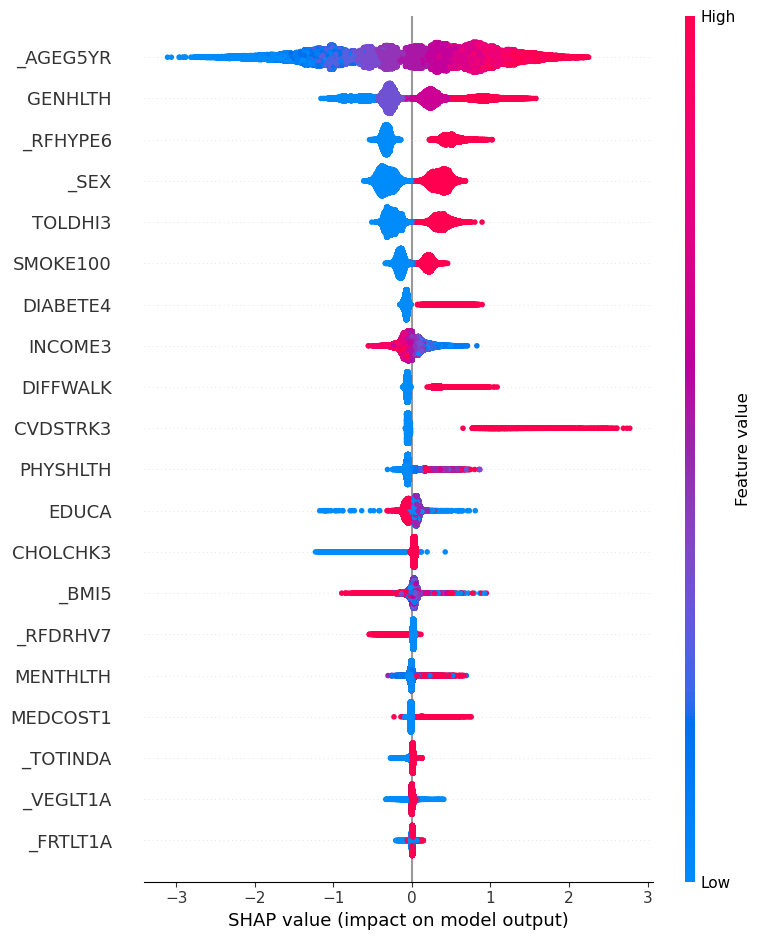

In [27]:
model = joblib.load('./baseline_lgbm.pkl')

# SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP 시각화
shap.summary_plot(shap_values[1], X_test)

#### 오분류 분석 - 1

In [19]:
# 오분류 분석 위한 데이터 준비

test = X_test
test['label'] = y_test
test['prediction'] = pred_test

- 나이대별 정답/오답 비교
- 연령대가 높아질수록 오답이 많아지는 모습을 확인할 수 있다. 

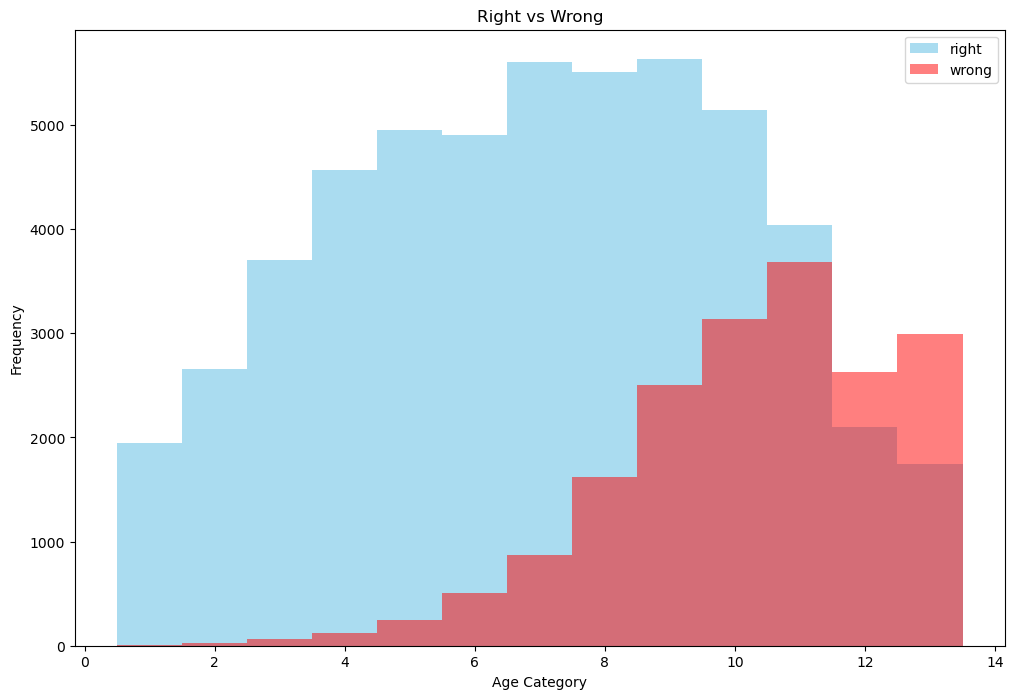

In [21]:
right = test[test['label']==test['prediction']] # 정답
wrong = test[test['label']!=test['prediction']] # 오답

counts_right = right['_AGEG5YR'].value_counts().sort_index()
counts_wrong = wrong['_AGEG5YR'].value_counts().sort_index()

# 공통 인덱스 확보
all_indexes = counts_right.index.union(counts_wrong.index)

# 빈도수를 DataFrame으로 합치고 NaN은 0으로 채우기
counts_df = pd.DataFrame({
    'right': counts_right.reindex(all_indexes, fill_value=0),
    'wrong': counts_wrong.reindex(all_indexes, fill_value=0)
})

# 플롯 생성
plt.figure(figsize=(12, 8))

# 맞게 분류된 데이터
plt.bar(counts_df.index, counts_df['right'], color='skyblue', width=1, label='right', alpha=0.7)

# 틀리게 분류된 데이터
plt.bar(counts_df.index, counts_df['wrong'], color='red', width=1, label='wrong', alpha=0.5)

plt.title('Right vs Wrong')
plt.xlabel('Age Category')
plt.ylabel('Frequency')
plt.legend()

plt.show()


#### 오분류 분석 - 2

- 고연령대의 오답이 대부분 False Positive 임을 알 수 있다. 

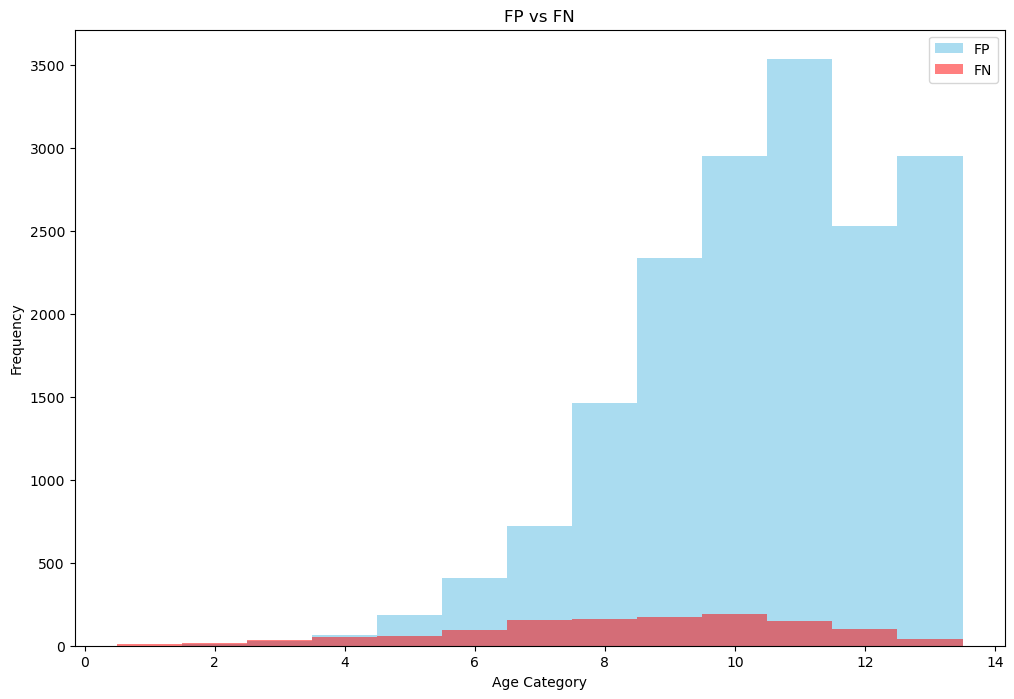

In [22]:
fp = test[(test['label']==0)&(test['prediction']==1)] # false positive
fn = test[(test['label']==1)&(test['prediction']==0)] # false negative

counts_fp = fp['_AGEG5YR'].value_counts().sort_index()
counts_fn = fn['_AGEG5YR'].value_counts().sort_index()

# 공통 인덱스 확보
all_indexes = counts_fp.index.union(counts_fn.index)

# 빈도수를 DataFrame으로 합치고 NaN은 0으로 채우기
counts_df = pd.DataFrame({
    'FP': counts_fp.reindex(all_indexes, fill_value=0),
    'FN': counts_fn.reindex(all_indexes, fill_value=0)
})

# 플롯 생성
plt.figure(figsize=(12, 8))

# false positive
plt.bar(counts_df.index, counts_df['FP'], color='skyblue', width=1, label='FP', alpha=0.7)

# false negative
plt.bar(counts_df.index, counts_df['FN'], color='red', width=1, label='FN', alpha=0.5)

plt.title('FP vs FN')
plt.xlabel('Age Category')
plt.ylabel('Frequency')
plt.legend()

plt.show()


## 3-2. Advanced Model

- Baseline Model의 분석 결과를 바탕으로, 연령대 편향을 제거한 공정성 모델을 구축한다. 
- 연령대 편향 제거에 따른 고연령층 예측 정확도 향상은 SMOTEENN으로 리샘플링된 데이터셋에서 뚜렷하게 관찰되었다.

In [42]:
# 데이터 준비
X_test = pd.read_pickle('./X_test_smoteenn.pkl')
y_test = pd.read_pickle('./y_test_smoteenn.pkl').squeeze()
X_train = pd.read_pickle('./X_train_smoteenn.pkl')
y_train = pd.read_pickle('./y_train_smoteenn.pkl').squeeze()

# 전체 데이터셋 생성
data = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

# AIF360 데이터셋 생성
dataset = StandardDataset(data, 
                          label_name='_MICHD',
                          favorable_classes=[0],
                          protected_attribute_names=['_AGEG5YR'],
                          privileged_classes=[[1]])

# Reweighing 알고리즘 적용
rw = Reweighing(unprivileged_groups=[{'_AGEG5YR': 0}], privileged_groups=[{'_AGEG5YR': 1}])
dataset_transformed = rw.fit_transform(dataset)

# 가중치 추출
weights = dataset_transformed.instance_weights

# 원본 모델 
original_model = joblib.load('./baseline_lr.pkl')
original_model.fit(X_train, y_train)

# 공정성 개선 모델 
fair_model = joblib.load('./baseline_lr.pkl')
fair_model.fit(X_train, y_train, sample_weight=weights)

# 예측 및 성능 평가 함수
def evaluate_model(model, X, y, name):
    pred = model.predict(X)
    acc = accuracy_score(y, pred)
    pre = precision_score(y, pred)
    re = recall_score(y, pred)
    f1 = f1_score(y, pred)
    aucc = roc_auc_score(y, pred)
    return pd.DataFrame({
        'Model': [name],
        'Accuracy': [acc],
        'Precision': [pre],
        'Recall': [re],
        'F1-score': [f1],
        'ROC AUC': [aucc]
    })

# 원본 모델 평가
original_train_scores = evaluate_model(original_model, X_train, y_train, "Original (Train)")
original_test_scores = evaluate_model(original_model, X_test, y_test, "Original (Test)")

# 공정성 개선 모델 평가
fair_train_scores = evaluate_model(fair_model, X_train, y_train, "Fair (Train)")
fair_test_scores = evaluate_model(fair_model, X_test, y_test, "Fair (Test)")

# 결과 출력
print("SMOTEENN & Logistic Regression (Original vs Fair)")
print('-'*50)
scores = pd.concat([original_train_scores, original_test_scores, fair_train_scores, fair_test_scores])
display(scores)

# 예측
original_train_pred = original_model.predict(X_train)
original_test_pred = original_model.predict(X_test)
fair_train_pred = fair_model.predict(X_train)
fair_test_pred = fair_model.predict(X_test)

SMOTEENN & Logistic Regression (Original vs Fair)
--------------------------------------------------


,Model,Accuracy,Precision,Recall,F1-score,ROC AUC
0,Original (Train),0.855103,0.886207,0.866153,0.876066,0.852636
0,Original (Test),0.701328,0.202036,0.831025,0.325048,0.760033
0,Fair (Train),0.853820,0.882196,0.868776,0.875435,0.850480
0,Fair (Test),0.696435,0.199508,0.832491,0.321877,0.758018


- 나이대별 정답률 비교
- 나이 편향 제거시, 고연령대에서 정답률이 미세하게 상승함을 알 수 있다. 

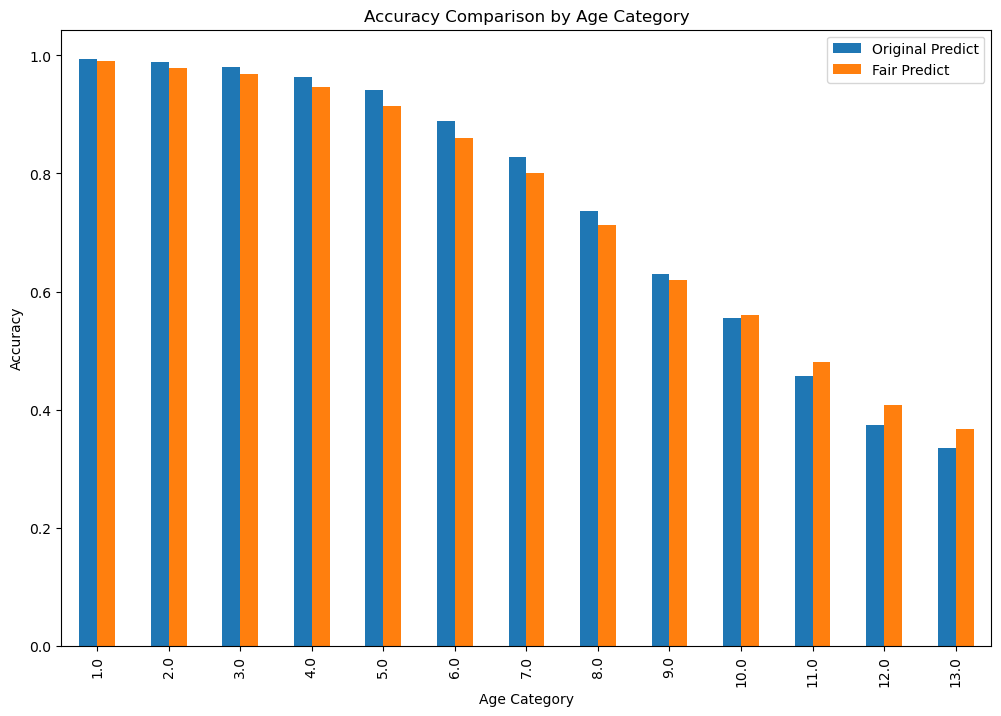

In [43]:
# 나이대별 정답률
test = X_test
test['label'] = y_test
test['original_predict'] = original_test_pred # 원 모델
test['fair_predict'] = fair_test_pred # 공정성 모델

# 데이터 준비
test = pd.DataFrame({
    'label': y_test,
    'original_predict': original_test_pred,
    'fair_predict': fair_test_pred,
    'age_cat': test['_AGEG5YR']  # age_cat 변수를 추가
})

# 나이대별 정답률 계산
grouped = test.groupby('age_cat').apply(lambda x: pd.Series({
    'original_accuracy': (x['label'] == x['original_predict']).mean(),
    'fair_accuracy': (x['label'] == x['fair_predict']).mean()
}))

# 시각화
grouped.plot(kind='bar', figsize=(12, 8))
plt.title('Accuracy Comparison by Age Category')
plt.ylabel('Accuracy')
plt.xlabel('Age Category')
plt.legend(['Original Predict', 'Fair Predict'])
plt.show()


## 3-3. More Advanced Model

- Advanced Model 결과를 바탕으로, StratifiedShuffleSplit 기법을 적용하여 새로운 모델 구축
- Train set와 Test set에서 연령 비율을 일정하게 유지하여, 모델이 특정 연령대에 과적합되거나 편향되는 것을 방지
- 원 데이터셋 / SMOTEENN / Tomek Links 데이터셋 중, 평가 수치가 가장 높은 SMOTEENN 데이터셋 사용

In [32]:
# '_AGEG5YR' 변수 처리 함수
# SMOTEENN으로 resampling된 데이터의 _AGEG5YR 열에 실수값이 포함되어 있으므로, 이를 반올림하여 원래의 정수형으로 변환한다.
def process_age_group(df):

    # 반올림하고 정수로 변환
    df['_AGEG5YR'] = df['_AGEG5YR'].round().astype(int)
    
    # 데이터 타입을 범주형으로 변경
    df['_AGEG5YR'] = df['_AGEG5YR'].astype('category')
    
    return df

In [33]:
# 데이터 로드
X_test = pd.read_pickle('./X_test_smoteenn.pkl')
y_test = pd.read_pickle('./y_test_smoteenn.pkl').squeeze()
X_train = pd.read_pickle('./X_train_smoteenn.pkl')
y_train = pd.read_pickle('./y_train_smoteenn.pkl').squeeze()

# X_train과 X_test에 함수 적용
X_train = process_age_group(X_train)
X_test = process_age_group(X_test)

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

# 인덱스 리셋
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [36]:
# StratifiedShuffleSplit을 사용하여 훈련/테스트 세트 분할 및 나이 그룹 층화
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in sss.split(X, X['_AGEG5YR']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# 모델 학습
model = LGBMClassifier(random_state=42, scale_pos_weight=10)
model.fit(X_train, y_train)

# 예측
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# 성능 메트릭 계산
def calculate_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_pred)
    }

train_metrics = calculate_metrics(y_train, pred_train)
test_metrics = calculate_metrics(y_test, pred_test)

# 결과 출력
print('\nStratified Sampling (by age group) + LightGBM')
print('test_size = 0.3, random_state=42')
print('-'*60)
scores = pd.DataFrame({
    ' ': ['Train', 'Test'],
    'accuracy': [train_metrics['accuracy'], test_metrics['accuracy']],
    'precision': [train_metrics['precision'], test_metrics['precision']],
    'recall': [train_metrics['recall'], test_metrics['recall']],
    'F1-score': [train_metrics['F1-score'], test_metrics['F1-score']],
    'roc_auc': [train_metrics['roc_auc'], test_metrics['roc_auc']],
})

display(scores)


Stratified Sampling (by age group) + LightGBM
test_size = 0.3, random_state=42
------------------------------------------------------------


,,accuracy,precision,recall,F1-score,roc_auc
0,Train,0.861503,0.782375,0.985347,0.872208,0.866343
1,Test,0.860624,0.782198,0.984185,0.871643,0.865184


- 고연령대에서 정답률 높아진 것 확인

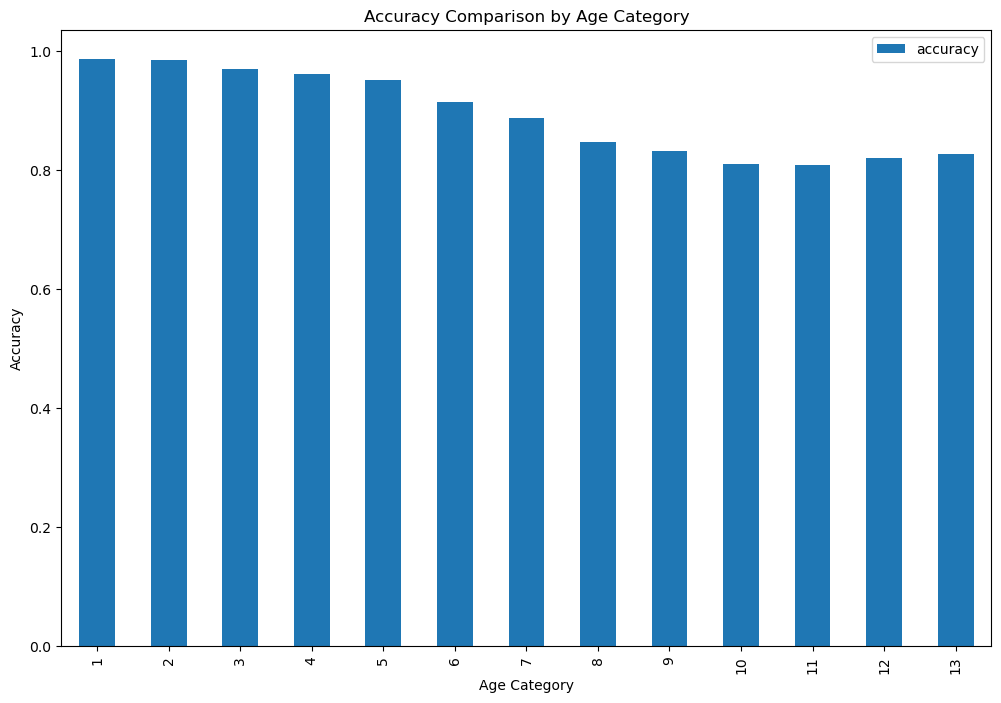

In [47]:
# 데이터 준비
test = pd.DataFrame({
    'label': y_test,
    'predict': pred_test,
    'age_cat': X_test['_AGEG5YR']
})

# 나이대별 정답률 계산
grouped = test.groupby('age_cat').apply(lambda x: pd.Series({
    'accuracy': (x['label'] == x['predict']).mean(),
}))

# 시각화
grouped.plot(kind='bar', figsize=(12, 8))
plt.title('Accuracy Comparison by Age Category')
plt.ylabel('Accuracy')
plt.xlabel('Age Category')
plt.show()

## 3-4. Hyper Parameter 최적화

- Optuna 사용

In [110]:
# StratifiedShuffleSplit을 사용하여 훈련/테스트 세트 분할 및 나이 그룹 층화
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in sss.split(X, X['_AGEG5YR']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# 하이퍼파라미터 튜닝을 위한 목적 함수
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),  # L1 regularization
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),  # L2 regularization
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),  # Maximum number of leaves in one tree
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),  # Subsample ratio of columns when constructing each tree
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),  # Subsample ratio of the training instance
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),  # Frequency of subsample, <=0 means no enable
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),  # Minimum number of data needed in a child (leaf)
        'scale_pos_weight': 10
    }

    model = LGBMClassifier(**param)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = roc_auc_score(y_test, pred) # roc_auc_score 기준으로 최적화 진행
    return score

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 최적 파라미터
best_params = study.best_trial.params

# 고정 파라미터 추가
best_params['random_state'] = 42
best_params['scale_pos_weight'] = 10

model = LGBMClassifier(**best_params)
model.fit(X_train, y_train)

# Train set, Test set 예측
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# 성능 메트릭 계산
acc_train = accuracy_score(y_train, pred_train)
pre_train = precision_score(y_train, pred_train)
re_train = recall_score(y_train, pred_train)
f1_train = f1_score(y_train, pred_train)
aucc_train = roc_auc_score(y_train, pred_train)

acc_test = accuracy_score(y_test, pred_test)
pre_test = precision_score(y_test, pred_test)
re_test = recall_score(y_test, pred_test)
f1_test = f1_score(y_test, pred_test)
aucc_test = roc_auc_score(y_test, pred_test)

print('Optuna Tuned LightGBM + Stratified SMOTEENN')
print('test_size = 0.3, random_state=42, stratify=y')
print('-'*30)
scores = pd.DataFrame({
    ' ': ['Train', 'Test'],
    'accuracy': [acc_train, acc_test],
    'precision': [pre_train, pre_test],
    'recall': [re_train, re_test],
    'F1-score': [f1_train, f1_test],
    'roc_auc': [aucc_train, aucc_test],
})

display(scores)

Optuna Tuned LightGBM + Stratified SMOTEENN
test_size = 0.3, random_state=42, stratify=y
------------------------------


,,accuracy,precision,recall,F1-score,roc_auc
0,Train,0.908355,0.844238,0.991956,0.912155,0.911623
1,Test,0.893321,0.831336,0.976192,0.897960,0.896379


In [109]:
# 최적화 파라미터 확인

best_params

{'reg_alpha': 0.06476523211387808,
 'reg_lambda': 1.847433514838012e-06,
 'num_leaves': 251,
 'colsample_bytree': 0.9720257660234648,
 'subsample': 0.4623986364744083,
 'subsample_freq': 3,
 'min_child_samples': 27,
 'random_state': 42,
 'scale_pos_weight': 10}

In [111]:
# 최종 모델 저장

joblib.dump(model, './model.pkl')

['./model.pkl']

# 4. 결과 

- 전반적인 수치 향상

    - accuracy: 0.89
    - precision: 0.83
    - recall: 0.97
    - F1-score: 0.90
    - roc_auc: 0.90

In [58]:
display(scores)

,,accuracy,precision,recall,F1-score,roc_auc
0,Train,0.908355,0.844238,0.991956,0.912155,0.911623
1,Test,0.893321,0.831336,0.976192,0.897960,0.896379


## 4-1. ROC curve

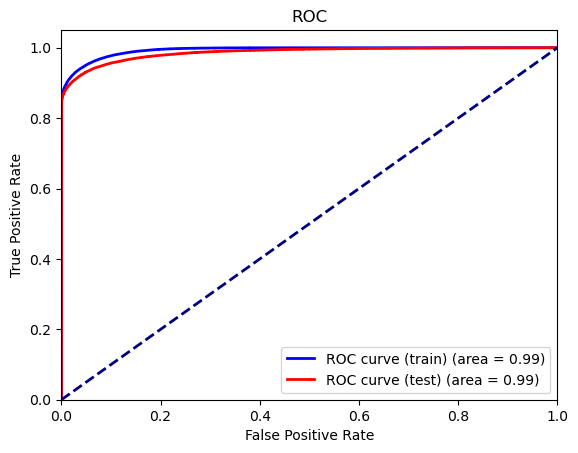

In [52]:
# ROC curve 그리기
y_train_proba = model.predict_proba(X_train)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]

# 데이터
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# 시각화
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (train) (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='ROC curve (test) (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## 4-2. Precision-Recall Curve

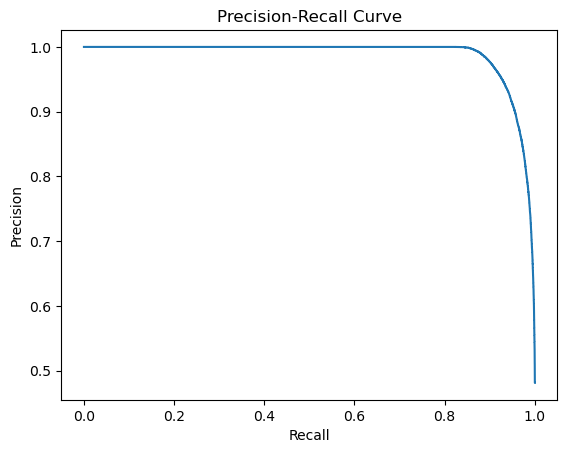

In [55]:
# 데이터 계산
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)

# 시각화
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()
plt.title('Precision-Recall Curve')
plt.show()


## 4-3. Precision-Recall by Threshold

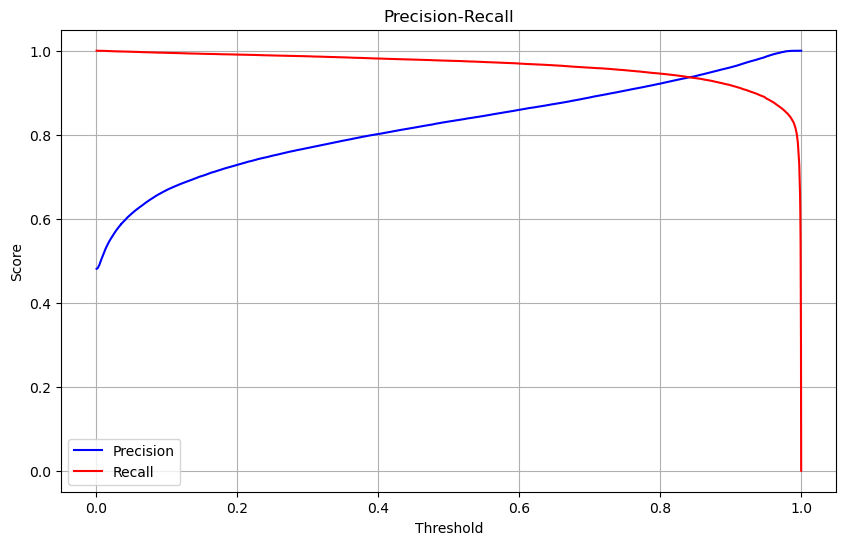

In [56]:
# 데이터 계산
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

# F1-score 계산
f1_scores = 2 * (precision * recall) / (precision + recall)

# Precision-Recall 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
plt.plot(thresholds, recall[:-1], 'r-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## 4-4. SHAP

- Feature importance 균등하게 분포함 확인

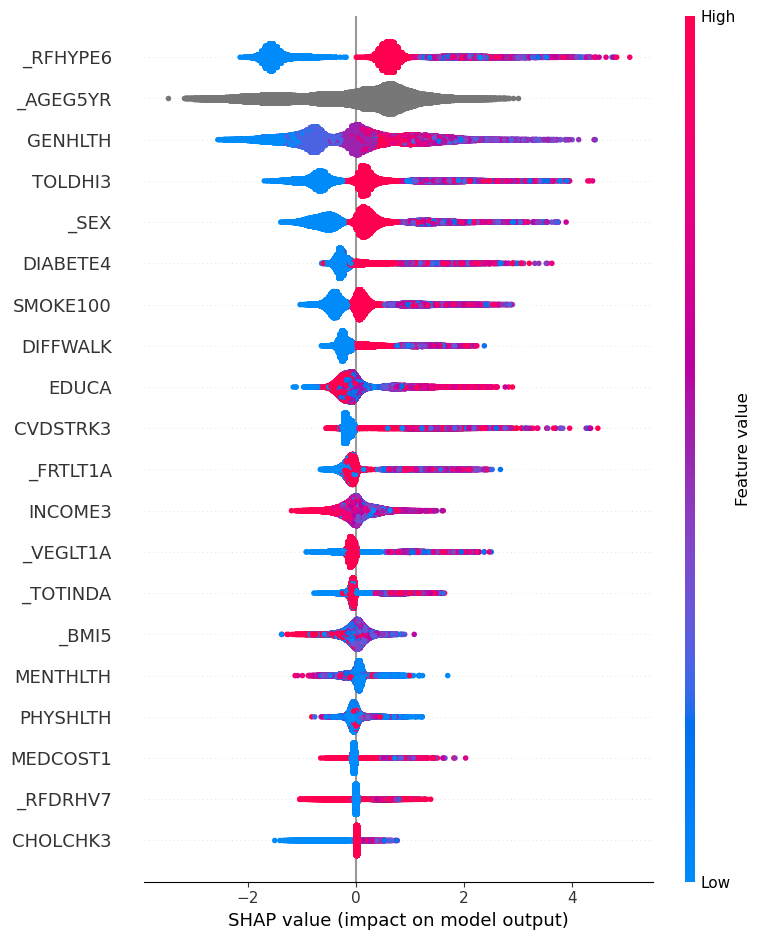

In [82]:
# SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP 시각화 (양성 예측)
shap.summary_plot(shap_values[1], X_test)